In [14]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import clear_output

print(torch.__version__)

2.4.1+cu121


In [12]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [13]:
import sys, os
if 'google.colab' in sys.modules and not os.path.exists('.setup_complete'):
    !wget -q https://raw.githubusercontent.com/yandexdataschool/deep_vision_and_graphics/fall22/week01-pytorch_intro/notmnist.py
    !touch .setup_complete

# Task 1. Tensors (1 point)

Let's write another function, this time in polar coordinates:
$$\rho(\theta) = (1 + 0.9 \cdot cos (8 \cdot \theta) ) \cdot (1 + 0.1 \cdot cos(24 \cdot \theta)) \cdot (0.9 + 0.05 \cdot cos(200 \cdot \theta)) \cdot (1 + sin(\theta))$$


Then convert it into cartesian coordinates ([howto](http://www.mathsisfun.com/polar-cartesian-coordinates.html)) and plot the results.

Use torch tensors only: no lists, loops, numpy arrays, etc.

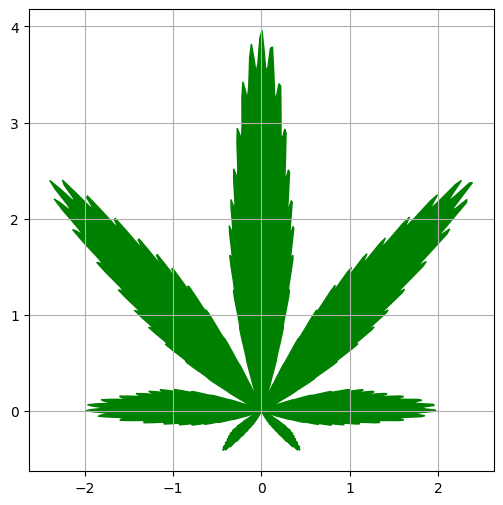

In [ ]:
theta = torch.linspace(- np.pi, np.pi, steps=1000)

# compute rho(theta) as per formula above
rho = (
    (1 + 0.9 * torch.cos(8 * theta)) *
    (1 + 0.1 * torch.cos(24 * theta)) *
    (0.9 + 0.05 * torch.cos(200 * theta)) *
    (1 + torch.sin(theta))
)

# Now convert polar (rho, theta) pairs into cartesian (x,y) to plot them.
x = rho * torch.cos(theta)
y = rho * torch.sin(theta)


plt.figure(figsize=[6, 6])
plt.fill(x.numpy(), y.numpy(), color='green')
plt.grid()

# Task 2: Going deeper (6 points)

Your ultimate task here is to build your first neural network [almost] from scratch and pure PyTorch.

This time you will solve the same digit recognition problem, but at a larger scale

* 10 different letters
* 20k samples

We want you to build a network that __reaches at least 80% accuracy__ and has __at least 2 linear layers__ in it.

With 10 classes you need __categorical crossentropy__  (see [here](http://wiki.fast.ai/index.php/Log_Loss)) loss. You can write it any way you want, but we recommend to use log_softmax function from pytorch, since it is more numerically stable.

Note that you are not required to build 152-layer monsters here. A 2-layer (one hidden, one output) neural network should already give you nice score.

__Win conditions:__
* __Your model must be nonlinear,__ but not necessarily deep.
* __Train your model with your own SGD__ - which you will have to implement
* __For this task only, please do not use the contents of `torch.nn` and `torch.optim`.__ That's for the next task.
* __Do not use Conv layers__

**Bonus:** For the best score in group you get +1.5, 1.0, 0.5 point(1st. 2nd, 3rd places).

In [ ]:
from notmnist import load_notmnist
X_train, y_train, X_val, y_val = load_notmnist(letters='ABCDEFGHIJ')
X_train, X_val = X_train.reshape([-1, 784]), X_val.reshape([-1, 784])

Extracting ...
Parsing...
found broken img: ./notMNIST_small/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png [it's ok if <10 images are broken]
found broken img: ./notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png [it's ok if <10 images are broken]
Done


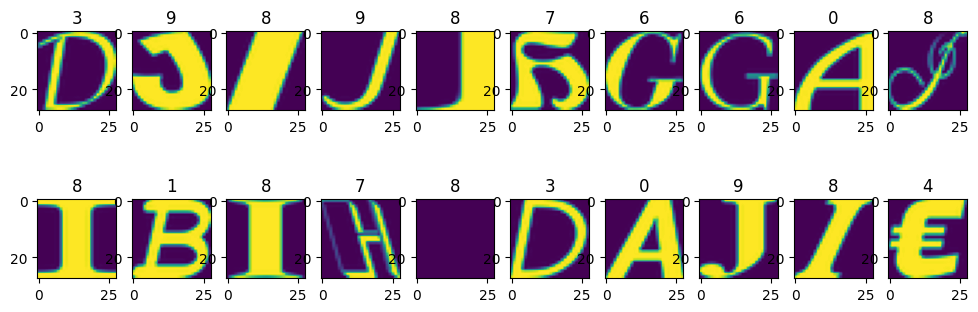

In [ ]:
%matplotlib inline
plt.figure(figsize=[12, 4])
for i in range(20):
    plt.subplot(2, 10, i+1)
    plt.imshow(X_train[i].reshape([28, 28]))
    plt.title(str(y_train[i]))

In [ ]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

In [ ]:
classes = np.unique(y_train)
n_classes = len(classes)
classes

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [ ]:
import math
import torch


class Module:
    def __init__(self):
        self.training = True

    def parameters(self):
        return []


class BatchNorm1d(Module):
    def __init__(
        self,
        f_in,
        device,
        eps=1e-5,
        momentum=0.1,
    ):
        super().__init__()
        self.eps = eps
        self.momentum = momentum

        self.f_in = f_in
        self.gamma = torch.ones(f_in, requires_grad=True, device=device)
        self.beta = torch.zeros(f_in, requires_grad=True, device=device)

        self.running_mean = torch.zeros(f_in, device=device)
        self.running_var = torch.ones(f_in, device=device)

    def forward(self, x):
        if self.training:
            mean = x.mean(dim=0)
            var = x.var(dim=0)
            self.running_mean = (
                1 - self.momentum
            ) * self.running_mean + self.momentum * mean
            self.running_var = (
                1 - self.momentum
            ) * self.running_var + self.momentum * var
        else:
            mean = self.running_mean
            var = self.running_var

        x_norm = (x - mean) / torch.sqrt(var + self.eps)
        out = self.gamma * x_norm + self.beta
        return out

    def parameters(self):
        return [self.gamma, self.beta]

    __call__ = forward


class Dropout(Module):
    def __init__(self, p=0.5, training=True):
        super().__init__()
        self.p = p

    def forward(self, x):
        if self.training:
            mask = torch.rand_like(x) > self.p
            x = x * mask / (1 - self.p)
        return x

    __call__ = forward


def kaiming_uniform(tensor):
    with torch.inference_mode():
        fan_in = tensor.size(1)
        bound = math.sqrt(6 / fan_in)
        tensor.uniform_(-bound, bound)
    return tensor


class Linear(Module):
    def __init__(self, f_in, f_out, device):
        super().__init__()
        self.W = torch.empty(f_in, f_out, requires_grad=True, device=device)
        self.b = torch.zeros(f_out, requires_grad=True, device=device)

        kaiming_uniform(self.W)

    def forward(self, x):
        return x @ self.W + self.b

    def parameters(self):
        return [self.W, self.b]

    __call__ = forward


class Sequential(Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = layers

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [param for layer in self.layers for param in layer.parameters()]

    __call__ = forward


class GELU(Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(math.sqrt(2 / math.pi) * (x + 0.044715 * torch.pow(x, 3))))

    __call__ = forward


class CustomNet:
    def __init__(
        self,
        hidden_size,
        dropout,
        in_size=28 * 28,
        num_classes=n_classes,
        device=DEVICE
    ):
        self.ffn = Sequential(
            [
                Linear(in_size, hidden_size, device),
                GELU(),
                BatchNorm1d(hidden_size, device),
                Dropout(dropout),

                Linear(hidden_size, hidden_size * 2, device),
                GELU(),
                BatchNorm1d(hidden_size * 2, device),
                Dropout(dropout),

                Linear(hidden_size * 2, hidden_size * 4, device),
                GELU(),
                BatchNorm1d(hidden_size * 4, device),
                Dropout(dropout),

                Linear(hidden_size * 4, hidden_size, device),
                GELU(),
                BatchNorm1d(hidden_size, device),
                Dropout(dropout),
            ]
        )

        self.clf = Linear(hidden_size, num_classes, device)
        print(f"Number of parameters: {self.count_parameters() / 1e6:.2f}M")

    def count_parameters(self):
        return sum(p.numel() for p in self.parameters())

    def forward(self, x):
        h = self.ffn(x)
        out = self.clf(h)
        return out

    def train(self):
        self.training = True
        for layer in self.ffn.layers:
            layer.training = True

    def eval(self):
        self.training = False
        for layer in self.ffn.layers:
            layer.training = False

    def parameters(self):
        return self.ffn.parameters() + self.clf.parameters()

    __call__ = forward

In [ ]:
net = CustomNet(40, 0.2)
out = net(torch.randn(2, 28*28, device=DEVICE))
assert len(out.shape) == 2
assert out.shape[-1] == n_classes

In [ ]:
import torch.nn.functional as F

def cross_entropy_loss(logits, target):
    # Get the log probabilities
    log_probs = F.log_softmax(logits, dim=-1)
    # Gather the log probabilities at the target indices
    log_probs_at_target = torch.gather(log_probs, dim=-1, index=target.unsqueeze(-1))
    # Compute the negative log likelihood
    nll = -log_probs_at_target.squeeze(-1)
    return nll.mean()

y_tmp = torch.tensor(y_train[:2], device=DEVICE)
cross_entropy_loss(out, y_tmp), torch.nn.CrossEntropyLoss()(out, y_tmp)

(tensor(2.6993, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(2.6993, device='cuda:0', grad_fn=<NllLossBackward0>))

In [ ]:
class CustomSGD:
    def __init__(self, model, lr=1e-4):
        self.model = model
        self.lr = lr

    def step(self):
        with torch.no_grad():
            for param in self.model.parameters():
                param.data -=  self.lr * param.grad.data
    def zero_grad(self):
        for param in self.model.parameters():
            param.grad = torch.zeros_like(param.grad)

In [ ]:
def iterate_minibatches(X, y, batch_size):
    indices = np.random.permutation(np.arange(len(X)))
    for start in range(0, len(indices), batch_size):
        ix = indices[start: start + batch_size]
        yield torch.from_numpy(X[ix]), torch.from_numpy(y[ix])

In [ ]:
def train(net, optimizer, loss_fn, n_epoch=20):
    loss_history = []
    acc_history = []
    val_loss_history = []
    val_acc_history = []

    for i in range(n_epoch):
        # Training
        net.train()
        acc_batches=[]
        loss_batches=[]
        for x_batch, y_batch in iterate_minibatches(X_train, y_train, batch_size=64):
            x_batch = x_batch.to(DEVICE)
            y_batch = y_batch.to(DEVICE)
            # Forward
            out = net.forward(x_batch)
            loss = loss_fn(out, y_batch)

            # Backward
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # Accuracy
            acc_batches += (out.argmax(axis=1) == y_batch).detach().cpu().numpy().tolist()
            loss_batches.append(loss.item())

        loss_history.append(np.mean(loss_batches))
        acc_history.append(np.mean(acc_batches))

        # Validating
        net.eval()
        with torch.no_grad():
            acc_batches=[]
            loss_batches=[]
            for x_batch, y_batch in iterate_minibatches(X_val, y_val, batch_size=64):
                x_batch = x_batch.to(DEVICE)
                y_batch = y_batch.to(DEVICE)
                # Forward
                out = net.forward(x_batch)
                loss = loss_fn(out, y_batch)
                # Accuracy
                acc_batches += (out.argmax(axis=1) == y_batch).detach().cpu().numpy().tolist()
                loss_batches.append(loss.item())

            val_loss_history.append(np.mean(loss_batches))
            val_acc_history.append(np.mean(acc_batches))

        clear_output(wait=True)
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
        ax1.set_xlabel("#epoch")
        ax1.set_ylabel("Loss")
        ax1.plot(loss_history, 'b', label='train loss')
        ax1.plot(val_loss_history, 'r', label='val loss')

        ax2.set_xlabel("#epoch")
        ax2.set_ylabel("Acc")
        ax2.plot(acc_history, 'b', label='train acc')
        ax2.plot(val_acc_history, 'r', label='val acc')
        plt.axhline(y = 0.8, color = 'g', linestyle = '--')

        plt.legend()
        plt.show()

        optimizer.lr *= 0.975
        print(optimizer.lr)

    return max(val_acc_history)

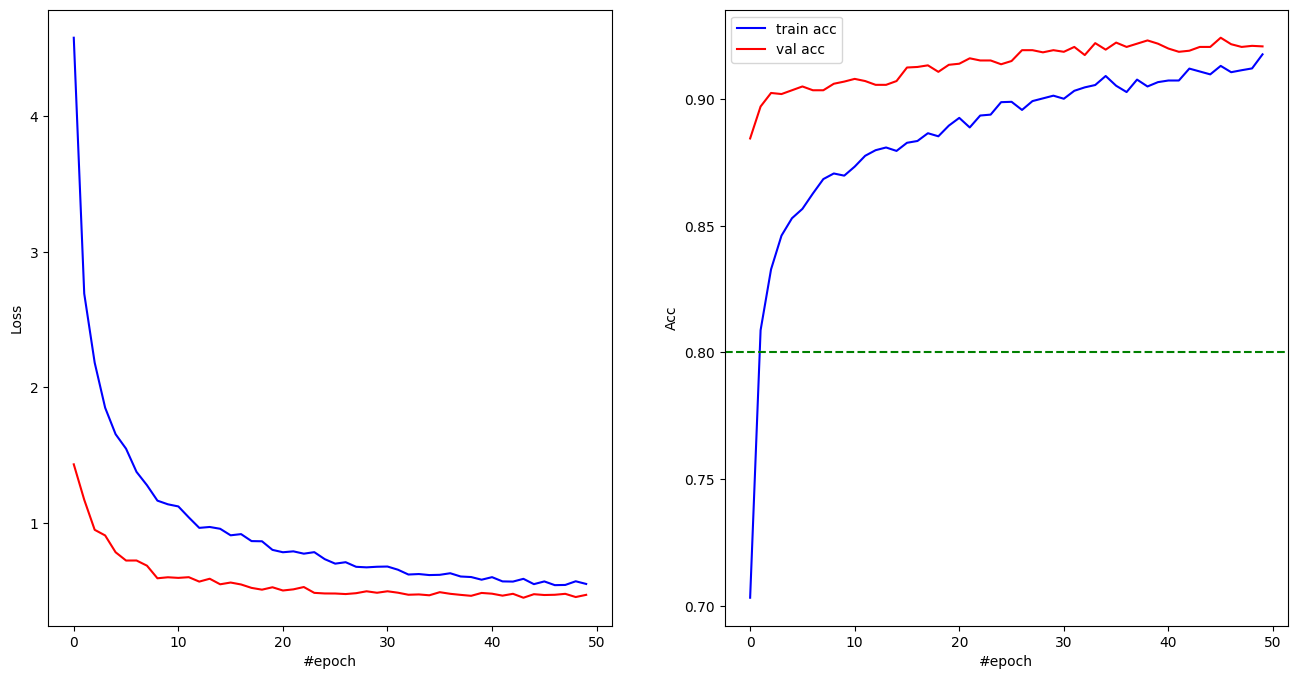

0.0014099405117045842


0.924161503952147

In [ ]:
net = CustomNet(512, 0.35)
opt = CustomSGD(net, lr=5e-3)
train(net, opt, cross_entropy_loss, n_epoch=50)

**0.9241**

### Hints:
  - You'll have to use matrix W(feature_id x class_id)
  - Softmax (exp over sum of exps) can be implemented manually or as `torch.softmax`
  - Probably better to use STOCHASTIC gradient descent (minibatch) for greater speed
  - You need to train both layers, not just the output layer :)
  - 50 hidden neurons and a ReLU nonlinearity will do for a start. Many ways to improve.
  - In ideal case this totals to 2 `torch.matmul`'s, 1 softmax and 1 ReLU/sigmoid  
  - If anything seems wrong, try going through one step of training and printing everything you compute.
  - If you see NaNs midway through optimization, you can estimate $\log P(y \mid x)$ as `torch.log_softmax(last_linear_layer_outputs)`.

# Task 3. Overfitting (4 points)


Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
0. Fill the gaps in training loop and architectures.
1. Train a tiny __FC__ network.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

Train a network that achieves $\geq 0.885$ test accuracy. Again you should use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

__Please, write a small report describing your ideas, tries and achieved results in the end of this task.__

*Note*: in task 3 your goal is to make the network from task 2 less prone to overfitting. And then to train the network that achives $\geq 0.885$ test accuracy, so it can be different.

**Bonus:** For the best score in group you get +1.5, 1.0, 0.5 point(1st, 2nd, 3rd places).

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary

from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os
from tqdm import tqdm
from sklearn.model_selection import train_test_split

In [2]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')

root_path = 'fmnist'
mkdir(root_path)

Directory fmnist is created!


In [3]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()

fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path,
                                                        train=True,
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path,
                                                       train=False,
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

100%|██████████| 26421880/26421880 [00:09<00:00, 2900977.07it/s]


Extracting fmnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to fmnist/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 144525.98it/s]


Extracting fmnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to fmnist/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:05<00:00, 851190.03it/s] 


Extracting fmnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to fmnist/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 21700780.90it/s]

Extracting fmnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to fmnist/FashionMNIST/raw



In [4]:
fmnist_dataset_train, fmnist_dataset_val = train_test_split(fmnist_dataset_train, train_size=50000)

In [5]:
len(fmnist_dataset_train), len(fmnist_dataset_val), len(fmnist_dataset_test)

(50000, 10000, 10000)

In [6]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train,
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)

val_loader = torch.utils.data.DataLoader(fmnist_dataset_val,
                                           batch_size=256,
                                           shuffle=True,
                                           num_workers=2)

test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

torch.Size([128, 1, 28, 28])
torch.Size([128])


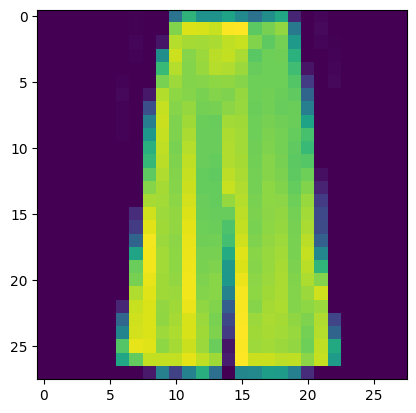

In [7]:
for img, label in train_loader:
    print(img.shape)
    # print(img)
    print(label.shape)
    break

plt.imshow(img[0, 0]);

In [8]:
def train_val_loop(net, train_loader, val_loader, name, optimizer, criterion, n_epoch=20):
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

    loss_history = []
    acc_history = []
    val_loss_history = []
    val_acc_history = []

    for i in range(n_epoch):
        net.train()
        acc_batches=[]
        loss_batches=[]
        for x_batch, y_batch in train_loader:
            x_batch = x_batch.to(DEVICE)
            y_batch = y_batch.to(DEVICE)
            # Forward
            out = net.forward(x_batch)
            loss = criterion(out, y_batch)
            # Backward
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # Accuracy
            acc_batches += (out.argmax(axis=1) == y_batch).detach().cpu().numpy().tolist()
            loss_batches.append(loss.item())

        loss_history.append(np.mean(loss_batches))
        acc_history.append(np.mean(acc_batches))

        # Validating
        net.eval()
        with torch.no_grad():
            acc_batches=[]
            loss_batches=[]
            for x_batch, y_batch in val_loader:
                x_batch = x_batch.to(DEVICE)
                y_batch = y_batch.to(DEVICE)
                # Forward
                out = net.forward(x_batch)
                loss = criterion(out, y_batch)
                # Accuracy
                acc_batches += (out.argmax(axis=1) == y_batch).detach().cpu().numpy().tolist()
                loss_batches.append(loss.item())

            val_loss_history.append(np.mean(loss_batches))
            val_acc_history.append(np.mean(acc_batches))

        scheduler.step(np.mean(loss_batches))

        clear_output(wait=True)
        plt.figure(figsize=(8, 5))
        plt.title(f"Training/validating loss {name}")
        plt.xlabel("#epoch")
        plt.ylabel("Loss")
        plt.plot(loss_history, 'b', label='train')
        plt.plot(val_loss_history, 'r', label='validation')
        plt.legend()

        plt.figure(figsize=(8, 5))
        plt.title(f"Training/validating accuracy {name}")
        plt.xlabel("#epoch")
        plt.ylabel("Accuracy")
        plt.plot(acc_history, 'b', label='train')
        plt.plot(val_acc_history, 'r', label='validation')
        plt.legend()

        plt.show()

def test_accuracy(model):
    model.eval()
    test_acc_batches = []
    with torch.no_grad():
        for X_test, Y_test in test_loader:
            X_test = X_test.to(DEVICE)
            Y_test = Y_test.to(DEVICE)
            out = model.forward(X_test)
            test_acc_batches += (out.argmax(axis=1) == Y_test).detach().cpu().numpy().tolist()
    print(f'Test accuracy {np.mean(test_acc_batches)}')

## Task 3.1 Tiny net
Train a tiny network just to validate correctness of train loop, net architecture, params.

In [12]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, hidden_size=40, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            nn.Linear(input_shape * input_channels, hidden_size),
            nn.GELU(),
            nn.Linear(hidden_size, hidden_size * 4),
            nn.GELU()

        )
        self.clf = nn.Linear(hidden_size * 4, num_classes)

    def forward(self, x):
        h = self.model(x)
        return self.clf(h)

In [13]:
model = TinyNeuralNetwork()
out = model(torch.randn(2, 1, 28, 28))
assert len(out.shape) == 2
assert out.shape[-1] == 10

In [14]:
torchsummary.summary(TinyNeuralNetwork().to(DEVICE), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                   [-1, 40]          31,400
              GELU-3                   [-1, 40]               0
            Linear-4                  [-1, 160]           6,560
              GELU-5                  [-1, 160]               0
            Linear-6                   [-1, 10]           1,610
Total params: 39,570
Trainable params: 39,570
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.15
Estimated Total Size (MB): 0.16
----------------------------------------------------------------


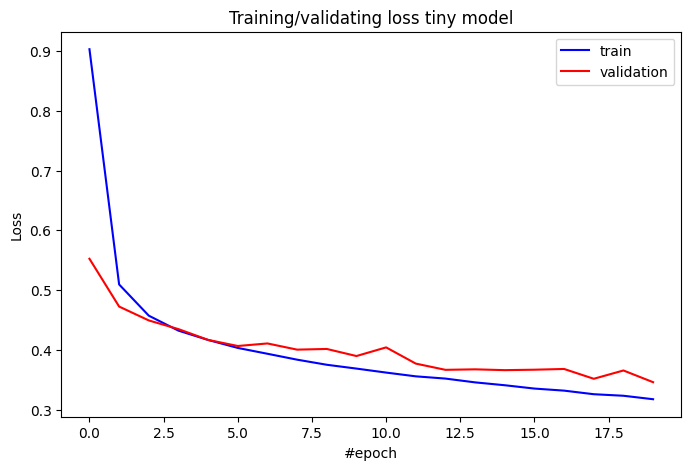

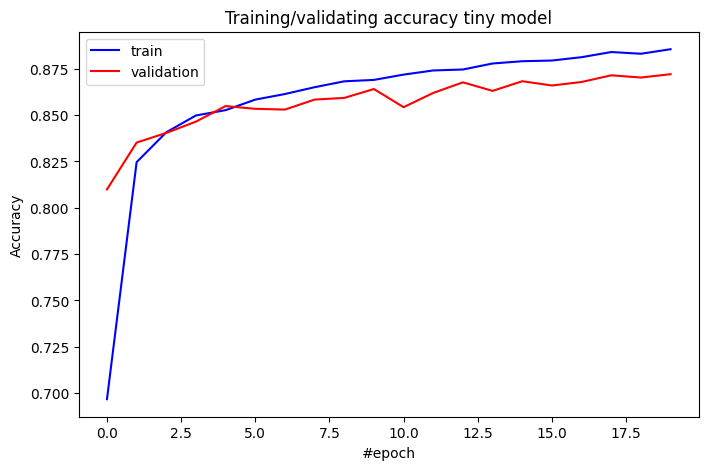

In [ ]:
tiny_model = TinyNeuralNetwork().to(DEVICE)
opt = torch.optim.AdamW(tiny_model.parameters(), lr=3e-4)
loss_func = nn.CrossEntropyLoss()
n_epoch = 20

# Your experiments, come here
train_val_loop(tiny_model, train_loader=train_loader, val_loader=val_loader, name='tiny model', optimizer=opt, criterion=loss_func, n_epoch=n_epoch)

In [ ]:
test_accuracy(tiny_model)

Test accuracy 0.8671


## Task 3.2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [19]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        hidden_size = 1024
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_shape * input_channels, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size * 2)
        self.fc3 = nn.Linear(hidden_size * 2, hidden_size * 4)
        self.fc4 = nn.Linear(hidden_size * 4, hidden_size * 8)
        self.fc5 = nn.Linear(hidden_size * 8, hidden_size * 16)
        self.fc6 = nn.Linear(hidden_size * 16, hidden_size * 8)
        self.fc7 = nn.Linear(hidden_size * 8, hidden_size * 4)
        self.fc8 = nn.Linear(hidden_size * 4, hidden_size * 2)
        self.fc9 = nn.Linear(hidden_size * 2, hidden_size)
        self.clf = nn.Linear(hidden_size, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.flatten(x)
        x1 = self.relu(self.fc1(x))
        x2 = self.relu(self.fc2(x1))
        x3 = self.relu(self.fc3(x2))
        x4 = self.relu(self.fc4(x3))
        x5 = self.relu(self.fc5(x4))
        x6 = self.relu(self.fc6(x5) + x4)
        x7 = self.relu(self.fc7(x6) + x3)
        x8 = self.relu(self.fc8(x7) + x2)
        x9 = self.relu(self.fc9(x8) + x1)
        out = self.clf(x9)
        return out

In [20]:
overfit_model = OverfittingNeuralNetwork()
out = overfit_model(torch.randn(2, 1, 28, 28))
assert len(out.shape) == 2
assert out.shape[-1] == 10

In [21]:
torchsummary.summary(OverfittingNeuralNetwork().to(DEVICE), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                 [-1, 1024]         803,840
              ReLU-3                 [-1, 1024]               0
            Linear-4                 [-1, 2048]       2,099,200
              ReLU-5                 [-1, 2048]               0
            Linear-6                 [-1, 4096]       8,392,704
              ReLU-7                 [-1, 4096]               0
            Linear-8                 [-1, 8192]      33,562,624
              ReLU-9                 [-1, 8192]               0
           Linear-10                [-1, 16384]     134,234,112
             ReLU-11                [-1, 16384]               0
           Linear-12                 [-1, 8192]     134,225,920
             ReLU-13                 [-1, 8192]               0
           Linear-14                 [-

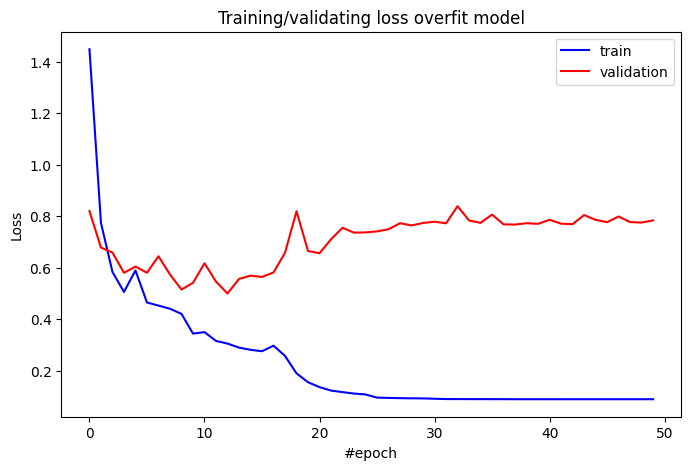

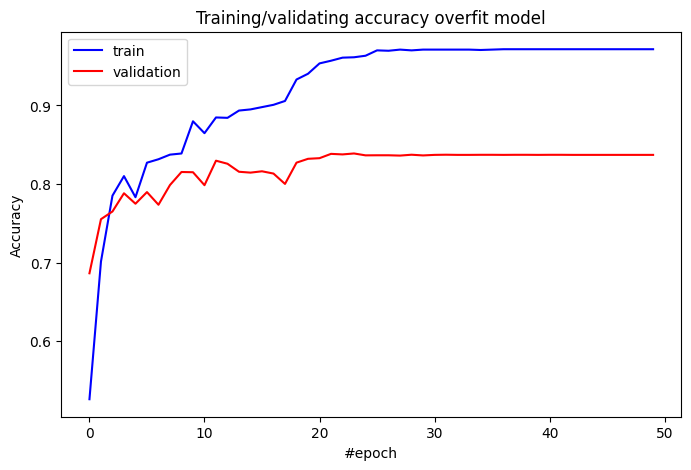

In [22]:
overfit_model = OverfittingNeuralNetwork().to(DEVICE)
opt = torch.optim.Adam(overfit_model.parameters(), lr=1e-3)
loss_func = nn.CrossEntropyLoss()
n_epoch = 50

of_loader = torch.utils.data.DataLoader(fmnist_dataset_train[:2048],
                                        batch_size=64,
                                        shuffle=True,
                                        num_workers=2)

# Your experiments, come here
train_val_loop(overfit_model, train_loader=of_loader, val_loader=val_loader, name='overfit model', optimizer=opt, criterion=loss_func, n_epoch=n_epoch)

In [23]:
test_accuracy(overfit_model)

Test accuracy 0.8299


## Task 3.3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

In [24]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        hidden_size = 1024
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_shape * input_channels, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size * 2)
        self.bn2 = nn.BatchNorm1d(hidden_size * 2)
        self.fc3 = nn.Linear(hidden_size * 2, hidden_size * 4)
        self.bn3 = nn.BatchNorm1d(hidden_size * 4)
        self.fc4 = nn.Linear(hidden_size * 4, hidden_size * 8)
        self.bn4 = nn.BatchNorm1d(hidden_size * 8)
        self.fc5 = nn.Linear(hidden_size * 8, hidden_size * 16)
        self.bn5 = nn.BatchNorm1d(hidden_size * 16)
        self.fc6 = nn.Linear(hidden_size * 16, hidden_size * 8)
        self.bn6 = nn.BatchNorm1d(hidden_size * 8)
        self.fc7 = nn.Linear(hidden_size * 8, hidden_size * 4)
        self.bn7 = nn.BatchNorm1d(hidden_size * 4)
        self.fc8 = nn.Linear(hidden_size * 4, hidden_size * 2)
        self.bn8 = nn.BatchNorm1d(hidden_size * 2)
        self.fc9 = nn.Linear(hidden_size * 2, hidden_size)
        self.bn9 = nn.BatchNorm1d(hidden_size)
        self.clf = nn.Linear(hidden_size, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.flatten(x)
        x1 = self.dropout(self.relu(self.bn1(self.fc1(x))))
        x2 = self.dropout(self.relu(self.bn2(self.fc2(x1))))
        x3 = self.dropout(self.relu(self.bn3(self.fc3(x2))))
        x4 = self.dropout(self.relu(self.bn4(self.fc4(x3))))
        x5 = self.dropout(self.relu(self.bn5(self.fc5(x4))))
        x6 = self.dropout(self.relu(self.bn6(self.fc6(x5) + x4)))
        x7 = self.dropout(self.relu(self.bn7(self.fc7(x6) + x3)))
        x8 = self.dropout(self.relu(self.bn8(self.fc8(x7) + x2)))
        x9 = self.dropout(self.relu(self.bn9(self.fc9(x8) + x1)))
        out = self.clf(x9)
        return out

In [25]:
model = FixedNeuralNetwork()
out = model(torch.randn(2, 1, 28, 28))
assert len(out.shape) == 2
assert out.shape[-1] == 10

In [26]:
torchsummary.summary(FixedNeuralNetwork().to(DEVICE), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                 [-1, 1024]         803,840
       BatchNorm1d-3                 [-1, 1024]           2,048
              ReLU-4                 [-1, 1024]               0
           Dropout-5                 [-1, 1024]               0
            Linear-6                 [-1, 2048]       2,099,200
       BatchNorm1d-7                 [-1, 2048]           4,096
              ReLU-8                 [-1, 2048]               0
           Dropout-9                 [-1, 2048]               0
           Linear-10                 [-1, 4096]       8,392,704
      BatchNorm1d-11                 [-1, 4096]           8,192
             ReLU-12                 [-1, 4096]               0
          Dropout-13                 [-1, 4096]               0
           Linear-14                 [-

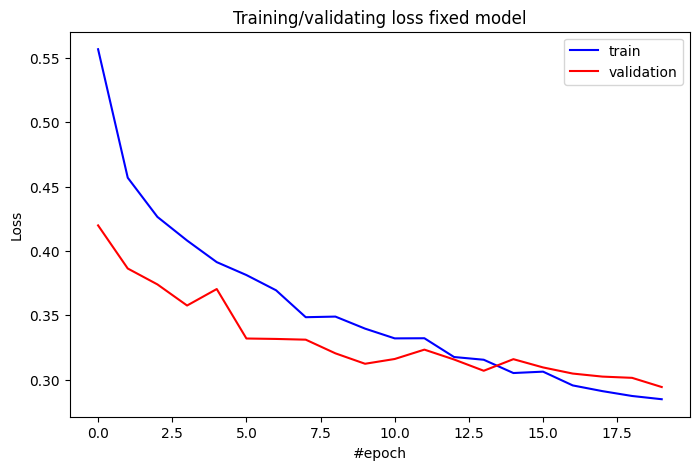

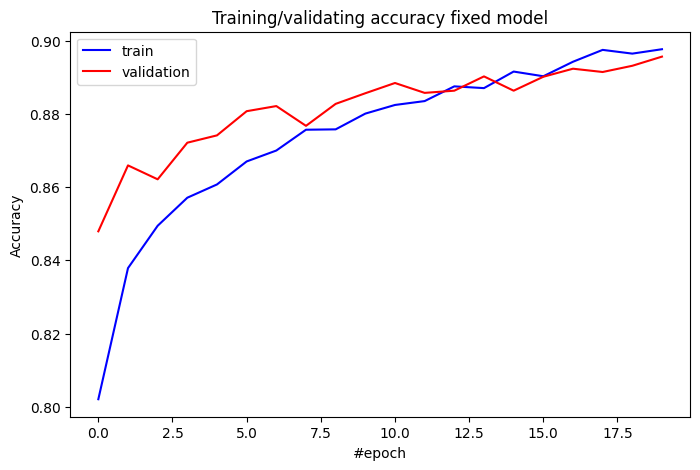

In [27]:
fixed_model = FixedNeuralNetwork().to(DEVICE)
opt = torch.optim.AdamW(fixed_model.parameters(), lr=1e-3)
loss_func = nn.CrossEntropyLoss()
n_epoch = 20

# Your experiments, come here
train_val_loop(fixed_model, train_loader=train_loader, val_loader=val_loader, name='fixed model', optimizer=opt, criterion=loss_func, n_epoch=n_epoch)

In [28]:
test_accuracy(fixed_model)

Test accuracy 0.8884


### Conclusions:
### Report and Conclusions

**Overfitting the Model:**
- To intentionally overfit the model, I reduced the training dataset size significantly and increased the model complexity, resulting in a model with 357 million parameters.
- This approach demonstrated clear overfitting, as evidenced by the divergence between training and validation performance.

**Fixing Overfitting:**
- To mitigate overfitting, I retained the complex model architecture but introduced regularization techniques such as Batch Normalization and Dropout layers.
- Additionally, I switched to the AdamW optimizer, which includes weight decay, to further regularize the model.
- I also reverted to using the full training dataset to ensure a more generalized learning process.
- Additionally, I employed early stopping by training the fixed model for fewer epochs to prevent overfitting.

**Results:**
- The combination of Batch Normalization, Dropout, and AdamW optimizer effectively reduced overfitting.
- The model achieved a balanced performance on both the training and validation datasets, indicating improved generalization.

# Task 4. Your own nn layer. (4 points)

In [ ]:
class Module(object):
    """
    Basically, you can think of a module as of a something (black box)
    which can process `input` data and produce `ouput` data.
    This is like applying a function which is called `forward`:

        output = module.forward(input)

    The module should be able to perform a backward pass: to differentiate the `forward` function.
    More, it should be able to differentiate it if is a part of chain (chain rule).
    The latter implies there is a gradient from previous step of a chain rule.

        gradInput = module.backward(input, gradOutput)
    """
    def __init__ (self):
        self.output = None
        self.gradInput = None
        self.training = True

    def forward(self, input):
        """
        Takes an input object, and computes the corresponding output of the module.
        """
        return self.updateOutput(input)

    def backward(self,input, gradOutput):
        """
        Performs a backpropagation step through the module, with respect to the given input.

        This includes
         - computing a gradient w.r.t. `input` (is needed for further backprop),
         - computing a gradient w.r.t. parameters (to update parameters while optimizing).
        """
        self.updateGradInput(input, gradOutput)
        self.accGradParameters(input, gradOutput)
        return self.gradInput


    def updateOutput(self, input):
        """
        Computes the output using the current parameter set of the class and input.
        This function returns the result which is stored in the `output` field.

        Make sure to both store the data in `output` field and return it.
        """

        # The easiest case:

        # self.output = input
        # return self.output

        pass

    def updateGradInput(self, input, gradOutput):
        """
        Computing the gradient of the module with respect to its own input.
        This is returned in `gradInput`. Also, the `gradInput` state variable is updated accordingly.

        The shape of `gradInput` is always the same as the shape of `input`.

        Make sure to both store the gradients in `gradInput` field and return it.
        """

        # The easiest case:

        # self.gradInput = gradOutput
        # return self.gradInput

        pass

    def accGradParameters(self, input, gradOutput):
        """
        Computing the gradient of the module with respect to its own parameters.
        No need to override if module has no parameters (e.g. ReLU).
        """
        pass

    def zeroGradParameters(self):
        """
        Zeroes `gradParams` variable if the module has params.
        """
        pass

    def getParameters(self):
        """
        Returns a list with its parameters.
        If the module does not have parameters return empty list.
        """
        return []

    def getGradParameters(self):
        """
        Returns a list with gradients with respect to its parameters.
        If the module does not have parameters return empty list.
        """
        return []

    def train(self):
        """
        Sets training mode for the module.
        Training and testing behaviour differs for Dropout, BatchNorm.
        """
        self.training = True

    def evaluate(self):
        """
        Sets evaluation mode for the module.
        Training and testing behaviour differs for Dropout, BatchNorm.
        """
        self.training = False

    def __repr__(self):
        """
        Pretty printing. Should be overrided in every module if you want
        to have readable description.
        """
        return "Module"

### Linear transform layer
Also known as dense layer, fully-connected layer, FC-layer.
You should implement it.

- input:   **`batch_size x n_feats1`**
- output: **`batch_size x n_feats2`**

In [ ]:
class Linear(Module):
    """
    A module which applies a linear transformation
    A common name is fully-connected layer, InnerProductLayer in caffe.

    The module should work with 2D input of shape (n_samples, n_feature).
    """
    def __init__(self, n_in, n_out):
        super(Linear, self).__init__()

        # This is a nice initialization
        stdv = 1./np.sqrt(n_in)
        #it is important that we should multiply X @ W^T
        self.W = np.random.uniform(-stdv, stdv, size = (n_out, n_in))
        self.b = np.random.uniform(-stdv, stdv, size = n_out)

        self.gradW = np.zeros_like(self.W)
        self.gradb = np.zeros_like(self.b)

    def updateOutput(self, input):
        self.output = input @ self.W.T + self.b
        return self.output


# X: (batch, f_in)
# W: (f_out, f_in)
# out: (batch, f_out)
# b: f_out
    def updateGradInput(self, input, gradOutput):
        self.gradInput = gradOutput @ self.W
        return self.gradInput

    def accGradParameters(self, input, gradOutput):
        self.gradW += gradOutput.T @ input
        self.gradb += np.sum(gradOutput.T, axis=1)

    def zeroGradParameters(self):
        self.gradW.fill(0)
        self.gradb.fill(0)

    def getParameters(self):
        return [self.W, self.b]

    def getGradParameters(self):
        return [self.gradW, self.gradb]

    def __repr__(self):
        s = self.W.shape
        q = 'Linear %d -> %d' %(s[1],s[0])
        return q

In [ ]:
def test_Linear():
    np.random.seed(42)
    torch.manual_seed(42)

    batch_size, n_in, n_out = 2, 3, 4
    for _ in range(100):
        # layers initialization
        torch_layer = torch.nn.Linear(n_in, n_out)
        custom_layer = Linear(n_in, n_out)
        custom_layer.W = torch_layer.weight.data.numpy()
        custom_layer.b = torch_layer.bias.data.numpy()

        layer_input = np.random.uniform(-10, 10, (batch_size, n_in)).astype(np.float32)
        next_layer_grad = np.random.uniform(-10, 10, (batch_size, n_out)).astype(np.float32)

        # 1. check layer output
        custom_layer_output = custom_layer.updateOutput(layer_input)
        layer_input_var = torch.from_numpy(layer_input).requires_grad_(True)
        torch_layer_output_var = torch_layer(layer_input_var)
        assert np.allclose(torch_layer_output_var.data.numpy(), custom_layer_output, atol=1e-6)

        # 2. check layer input grad
        custom_layer_grad = custom_layer.updateGradInput(layer_input, next_layer_grad)
        torch_layer_output_var.backward(torch.from_numpy(next_layer_grad))
        torch_layer_grad_var = layer_input_var.grad
        assert np.allclose(torch_layer_grad_var.data.numpy(), custom_layer_grad, atol=1e-6)

        # 3. check layer parameters grad
        custom_layer.accGradParameters(layer_input, next_layer_grad)
        weight_grad = custom_layer.gradW
        bias_grad = custom_layer.gradb
        torch_weight_grad = torch_layer.weight.grad.data.numpy()
        torch_bias_grad = torch_layer.bias.grad.data.numpy()
        assert np.allclose(torch_weight_grad, weight_grad, atol=1e-6)
        assert np.allclose(torch_bias_grad, bias_grad, atol=1e-6)

In [ ]:
%%time
test_Linear()

CPU times: user 71.6 ms, sys: 2.07 ms, total: 73.6 ms
Wall time: 73.4 ms
